In [4]:
import ee
import geemap

In [5]:
cloud_project = 'ee-robertzakayo4'

try:
    ee.Initialize(project=cloud_project)
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)

In [6]:
geometry = ee.Geometry.Polygon([[
  [120.42512705971974,15.689038296121959],
  [120.86046031167287,15.689038296121959],
  [120.86046031167287,16.130146719253414],
  [120.42512705971974,16.130146719253414],
  [120.42512705971974,15.689038296121959]
]])

In [7]:
#fao3 = ee.FeatureCollection("FAO/GAUL/2015/level2")

In [8]:
Pangasinan = fao3.filter(ee.Filter.eq('ADM2_NAME', 'Pangasinan'))
geometry = Pangasinan.geometry()

In [9]:
m = geemap.Map(width=800)
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [10]:
#m.addLayer(fao3, {}, 'FAO')
m.addLayer(geometry, {"color": 'grey'}, 'Pangasinan Region')
m.centerObject(geometry, 11)
m

Map(bottom=749.0, center=[15.993815328564603, 120.31171158956336], controls=(WidgetControl(options=['position'…

In [11]:
import ee
import math
import geemap


In [12]:
m = geemap.Map()

In [13]:
# Define parameters
interval = 7
unit = 'day'
startDate = ee.Date.fromYMD(2020, 11, 1)
endDate = ee.Date.fromYMD(2021, 3, 30)

# Load Sentinel-1 collection
s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
.filterBounds(geometry) \
.filterDate(startDate, endDate) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.eq('instrumentMode', 'IW'))\
.filter(ee.Filter.eq('relativeOrbitNumber_start', 32))\
.select(['VV', 'angle'])

print(s1.getInfo())
m.addLayer(s1.median().clip(geometry), {}, 'Sentinel1')
m

{'type': 'ImageCollection', 'bands': [], 'version': 1741323585936577, 'id': 'COPERNICUS/S1_GRD', 'features': [{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [28455, 21803], 'crs': 'EPSG:32651', 'crs_transform': [10, 0, 169074.3348359529, 0, -10, 1862542.532151093]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [21, 10], 'crs': 'EPSG:32651', 'crs_transform': [-12512.62562047859, -4054.1630259910016, 453531.17689118854, 2520.2281053753104, -20061.837360445876, 1811682.5452793941]}], 'version': 1741323585936577, 'id': 'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20201104T214637_20201104T214702_035104_0418C5_F19E', 'properties': {'SNAP_Graph_Processing_Framework_GPF_vers': '7.0.3', 'SLC_Processing_facility_org': 'ESA', 'SLC_Processing_facility_country': 'Germany', 'GRD_Post_Processing_facility_org': 'ESA', 'transmitterReceiverPolarisation': ['VV', 'VH'], 'GRD_Post_Processing_start': 1604602

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [14]:
# Aggregate to 7-day composites
interval = 7;
numDays = endDate.difference(startDate, 'day').floor()
daysList = ee.List.sequence(0, numDays, interval)

def func_vgn(days):
    compositeStart = startDate.advance(days, 'day')
    compositeEnd = compositeStart.advance(interval, 'day')
    periodImages =  s1.filterDate(compositeStart, compositeEnd)
    composite = ee.Algorithms.If(
        periodImages.size().gt(0),
        periodImages.mean().set({
            'system:time_start': compositeStart.millis(),
            'system:time_end': compositeEnd.millis(),
            'start_date': compositeStart.format('YYYY-MM-dd'),
            'end_date': compositeEnd.format('YYYY-MM-dd'),
            'num_images': periodImages.size()
        }),
        None  # Return None if no images in the period
    )

    return composite

daysImages = daysList.map(func_vgn).removeAll([None])

# Create a collection and remove empty composites
compositesCol = ee.ImageCollection.fromImages(daysImages)

# Print collection info
print(compositesCol.getInfo())


{'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:index': '0', 'system:time_start': 1604188800000, 'end_date': '2020-11-08', 'system:time_end': 1604793600000, 'num_images': 1, 'start_date': '2020-11-01'}}, {'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:index': '1', 'system:time_start': 1605398400000, 'end_date': '2020-11-22', 'system:time_end': 1606003200000, 'num_images': 1, 'start_date': '2020-11-15'}}, {'type

In [15]:
# Convert Sigma0 to Beta0 (Beta = Sigma0 / cos(incidence_angle))

def func_vfk(image):
    angle = image.select('angle').multiply(math.pi / 180)
    beta = image.select('VV').divide(angle.cos()).rename('Beta_VV')
    return image.addBands(beta)

BetaCalibration = func_vfk

# Apply calibration
s1_beta = compositesCol.map(BetaCalibration)

print(s1_beta.getInfo())
#m.addLayer(s1_beta.first().clip(geometry), {}, 's1_beta')

# Apply median smoothing

def func_ubg(image):
    smoothedVV = image.select('VV').focalMedian(3).rename('Smoothed_VV')
    smoothedBetaVV = image.select('Beta_VV').focalMedian(3).rename('Smoothed_Beta_VV')
    return image.addBands([smoothedVV, smoothedBetaVV], None, True)

smoothed = s1_beta.map(func_ubg)

print(smoothed.getInfo())
#m.addLayer(smoothed.first().clip(geometry), {}, 'smoothed')

{'type': 'ImageCollection', 'bands': [], 'features': [{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Beta_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:index': '0', 'system:time_start': 1604188800000, 'end_date': '2020-11-08', 'system:time_end': 1604793600000, 'num_images': 1, 'start_date': '2020-11-01'}}, {'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Beta_VV', 'data_type': {'type': 'PixelType'

In [16]:
# Compute min and max for normalization
vvMin = smoothed.select('Smoothed_VV').reduce(ee.Reducer.min())
vvMax = smoothed.select('Smoothed_VV').reduce(ee.Reducer.max())
print(vvMin.getInfo())
print(vvMax.getInfo())
#m.addLayer(vvMin.clip(geometry), {}, 'vvMin')
#m.addLayer(vvMax.clip(geometry), {}, 'vvMax')

# Compute Wetness Index (WI)

def func_xpk(image):
    wi = image.expression(
    '(VV - min) / (max - min)', {
            'VV': image.select('Smoothed_Beta_VV'),
            'min': vvMin,
            'max': vvMax
        }).rename('WI')
    return image.addBands(wi)

WI = func_xpk

wiCollection = smoothed.map(WI)

print (wiCollection.size())

{'type': 'Image', 'bands': [{'id': 'Smoothed_VV_min', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
{'type': 'Image', 'bands': [{'id': 'Smoothed_VV_max', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
ee.Number({
  "functionInvocationValue": {
    "functionName": "Collection.size",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_5_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.addBands",
                    "arguments": {
                      "dstImg": {
                        "argumentReference": "_MAPPING_VAR_5_0"
  

In [17]:
# Define a visualization palette for WI

turbo_r= [
'#6F0E10',  # Dark Purple
'#9D1A1C',  # Purple
'#C92A1D',  # Blue
'#F8991A',  # Light Blue
'#FBB034',  # Cyan
'#E4E60E',  # Light Green
'#9CDA68',  # Yellow
'#3FD8E5',  # Orange
'#00A3E0',  # Dark Orange
'#3B5A8D',  # Red
'#4A0F75',  # Dark Red
'#30123E'   # Dark Maroon
]
wiVis = {
    "min": -1,
    "max": 1,
    "palette":turbo_r

}
m.addLayer(wiCollection.first().select(['WI']).clip(geometry),wiVis, 'WI')
m

Map(bottom=59997.0, center=[15.83189336454005, 120.75578458534399], controls=(WidgetControl(options=['position…

In [18]:
# WI change between consecutive acquisitions
listWI = wiCollection.toList(wiCollection.size())
print(listWI.getInfo())

# Filter the Dynamic World collection
dwFiltered = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
.filter(ee.Filter.date(startDate, endDate)) \
.filter(ee.Filter.bounds(geometry))

probabilityBands = [
'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
]

probabilityImage = dwFiltered.select(probabilityBands).mean()
# Extract Crops and Flooded Vegetation
crops = dwFiltered.select('crops').median().clip(geometry)
floodedVegetation = dwFiltered.select('flooded_vegetation').median().clip(geometry)

# Visualization parameters
cropsVis = {"min": 0, "max": 1, "palette": ['white', 'green']}
floodedVegetationVis = {"min": 0, "max": 1, "palette": ['white', 'blue']}

# Add layers to the map
m.addLayer(crops.selfMask(), cropsVis, 'Detected Crops')
m.addLayer(floodedVegetation.selfMask(), floodedVegetationVis, 'Detected Flooded Vegetation')
m

[{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Beta_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Smoothed_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Smoothed_Beta_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'WI', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:index': '0', 'system:time_start': 1604188800000, 'end_date': '2020-11-08', 'system:time_end': 1604793600000, 'num_images': 1, 'start_date

Map(bottom=59997.0, center=[15.83189336454005, 120.75578458534399], controls=(WidgetControl(options=['position…

In [19]:
# crops mask
cropMask = crops.selfMask()

m.addLayer(cropMask, {"color": 'green'}, 'Crops')
# Apply crop mask to WI collection

def func_lwt(image):
    return image.updateMask(cropMask)

wiCollectionCrops = wiCollection.map(func_lwt)

# WI change between consecutive acquisitions (for crops only)
listWI = wiCollectionCrops.toList(wiCollectionCrops.size())

print(listWI.getInfo())

def func_llz(i):
    current = ee.Image(listWI.get(ee.Number(i).subtract(1)))
    next = ee.Image(listWI.get(i))
    diff = next.select('WI').subtract(current.select('WI')).rename('WI_Change')
    return diff.updateMask(cropMask).set('"system":time_start', next.get('"system":time_start'))

changeCollection = ee.ImageCollection(ee.List.sequence(1, listWI.size().subtract(1)).map(func_llz

))

[{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3, 2], 'origin': [119, 15], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [3, 2], 'origin': [119, 15], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Beta_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3, 2], 'origin': [119, 15], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Smoothed_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3, 2], 'origin': [119, 15], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'Smoothed_Beta_VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3, 2], 'origin': [119, 15], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'WI', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dim

In [21]:
# Compute the average WI change for crops
changeCollection = ee.ImageCollection(ee.List.sequence(1, listWI.size().subtract(1)).map(func_llz

))
meanWIChangeCrops = changeCollection.mean().rename('Mean_WI_Change').updateMask(cropMask)

# Classification based on WI change (only for crop areas)
classifiedCrops = meanWIChangeCrops.expression(
"(b('Mean_WI_Change') < -0.05) ? 1" +
" : (b('Mean_WI_Change') >= -0.05 && b('Mean_WI_Change') <= 0.05) ? 2" +
" : 3",
{}
).rename('Trend_Class').updateMask(cropMask)

# Smoothed WI change for crops
smoothedWIChangeCrops = meanWIChangeCrops.focalMean(5, 'square', 'pixels').updateMask(cropMask)

# Visualization parameters
vizParams = {
    "min": 1, "max": 3,
    "palette": ['red', 'yellow', 'blue']
}

heatmapVis = {
    "min": -0.1, "max": 0.1,
    "palette": ['#800026', '#BD0026', '#E31A1C', '#FC4E2A', '#FD8D3C',
    '#FEB24C', '#FED976', '#FFEDA0', '#FFFFCC', '#E0F3F8',
    '#91BFDB', '#4575B4', '#313695'] # Red to Blue gradient
}

# Add layers to map (for crop areas only)
m.addLayer(meanWIChangeCrops.clip(geometry), {"min": -0.1, "max": 0.1, "palette": ['red', 'yellow', 'blue']}, 'Mean WI Change (Crops)')
m.addLayer(classifiedCrops.clip(geometry), vizParams, 'Trend Classification (Crops)')
m.addLayer(smoothedWIChangeCrops.clip(geometry), heatmapVis, 'Smoothed WI Change Heatmap (Crops)')
m

Map(bottom=59997.0, center=[15.83189336454005, 120.75578458534399], controls=(WidgetControl(options=['position…

In [23]:
# Compute area per pixel in square kilometers
areaImage = ee.Image.pixelArea().divide(1e6)

# Calculate total area per class
classStats = areaImage.addBands(classifiedCrops) \
    .reduceRegion(
        reducer=ee.Reducer.sum().group(
            groupField=1,
            groupName='class'
        ),
        geometry=geometry,
        scale=1000,
        maxPixels=1e13
    )

print('Class Area Statistics:', classStats.getInfo())

# Extract class areas and format data for plotting
classData = ee.List(classStats.get('groups'))

# Function to format class names and areas
def func_ydm(obj):
    obj = ee.Dictionary(obj)
    classNum = ee.Number(obj.get('class'))

    className = ee.Algorithms.If(
        classNum.eq(1), 'Drying',
        ee.Algorithms.If(classNum.eq(2), 'Stable', 'Wetting')
    )

    return ee.Feature(None, {
        'Class': className,
        'Area_km2': obj.get('sum')
    })

# Apply function to each element in classData
classFeatureCollection = ee.FeatureCollection(classData.map(func_ydm))


Class Area Statistics: {'groups': [{'class': 1, 'sum': 2718.2717860928806}, {'class': 2, 'sum': 935.2734106068685}, {'class': 3, 'sum': 1553.0544586384879}]}


In [26]:
# Generate Pie Chart
pieChart = geemap.Chart.feature.byFeature(
    features=classFeatureCollection,
    xProperty='Class',
    yProperties=['Area_km2']
) \
.setChartType('PieChart') \
.setOptions({
    "title": "WI Change Wet-Season 2024",
    "slices": {
        0: {"color": 'red'},    # Drying
        1: {"color": 'yellow'}, # Stable
        2: {"color": 'blue'}    # Wetting
    },
    "width": 400,
    "height": 300
})

# Display chart
print(pieChart.getInfo())


AttributeError: module 'geemap' has no attribute 'Chart'

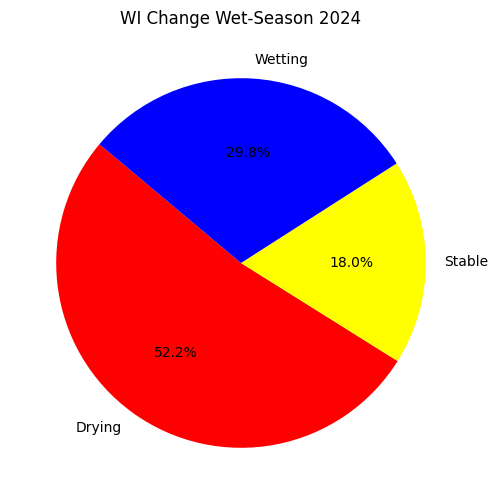

In [27]:
import matplotlib.pyplot as plt

# Get data from the FeatureCollection
class_list = classFeatureCollection.aggregate_array('Class').getInfo()
area_list = classFeatureCollection.aggregate_array('Area_km2').getInfo()

# Define colors for the classes
colors = {'Drying': 'red', 'Stable': 'yellow', 'Wetting': 'blue'}
class_colors = [colors[c] for c in class_list]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(area_list, labels=class_list, colors=class_colors, autopct='%1.1f%%', startangle=140)
plt.title('WI Change Wet-Season 2024')
plt.show()


In [ ]:
# # Add classified map to the viewer
# m.addLayer(classifiedCrops.clip(geometry), {
    #   "min": 1, "max": 3
    #   "palette": ['red', 'yellow', 'blue'] # Red = Drying, Yellow = Stable, Blue = Wetting
# }, 'Trend Classification (Crops)')
m

PNG file saved: class_area_chart.png


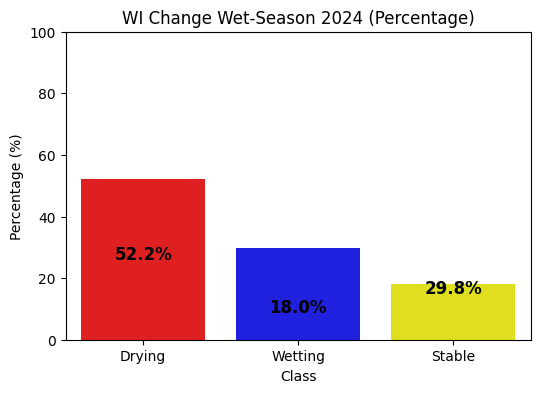

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract data from FeatureCollection
class_list = classFeatureCollection.aggregate_array('Class').getInfo()
area_list = classFeatureCollection.aggregate_array('Area_km2').getInfo()

# Convert to DataFrame
df = pd.DataFrame({'Class': class_list, 'Area_km2': area_list})

# Compute percentage
df['Percentage'] = (df['Area_km2'] / df['Area_km2'].sum()) * 100

# Sort classes for better visualization
df = df.sort_values('Percentage', ascending=False)

# Define colors
colors = {'Drying': 'red', 'Stable': 'yellow', 'Wetting': 'blue'}

# Create a stacked bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Class', y='Percentage', data=df, palette=colors, dodge=False)

# Add percentage labels
for index, row in df.iterrows():
    plt.text(index, row['Percentage'] / 2, f"{row['Percentage']:.1f}%",
             ha='center', color='black', fontsize=12, fontweight='bold')

# Set labels
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.title('WI Change Wet-Season 2024 (Percentage)')
plt.ylim(0, 100)
# Save the figure as PNG
png_WetSeason2024 = "class_area_chart.png"
plt.savefig(png_WetSeason2024, dpi=300, bbox_inches='tight')
print(f"PNG file saved: {png_WetSeason2024}")
# Show plot
plt.show()

